# Machine Learning with scikit-learn

Tutors: Jaime Rodríguez-Guerra (jaime.rodriguez@charite.de), Jan Philipp Albrecht (j.p.albrecht@fu-berlin.de)

> Based on [previous work](https://github.com/volkamerlab/TeachOpenCADD/blob/master/talktorials/7_machine_learning/T7_machine_learning.ipynb) by Jan Philipp Albrecht and Jacob Gora

# 1. Aims of this session

Familiarize yourself with the ground concepts of machine learning while you apply popular algorithms and patterns in Python's `scikit-learn`.

# Learning goals


## Theory

* Machine Learning (ML) methods
* Data preparation

## Practical

* Prepare your data
* Use regression to find correlations between MMSE and hippocampus volume
* Apply Random Forests to predict Alzheimer's disease based on volumetric measurements and other variables
* Cluster with k-means to guess the thresholds used for MMSE-based diagnosis
* Validate your models

# References

* ML:
    * Random forest (RF): [http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf)
    * Support vector machines (SVM): [https://link.springer.com/article/10.1007%2FBF00994018](https://link.springer.com/article/10.1007%2FBF00994018)
    * Artificial neural networks (ANN): [https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing](https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing)
* Performance: 
    * [Sensitivity and specificity (Wikipedia)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
    * [Roc curve and AUC (Wikipedia)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
* See also [this notebook by B. Merget](https://github.com/Team-SKI/Publications/tree/master/Profiling_prediction_of_kinase_inhibitors) from [*J. Med. Chem.*, 2017, 60, 474−485](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b01611) 

## Theory


### Supervised vs unsupervised learning

In supervised learning, the algorithm is fed data that is well labelled (e.g. classification); e.g. some of the data will be tagged with/as the correct answer. In unsupervised learning, the algorithm infers the labels (e.g. clustering).


### Machine Learning (ML)

ML can be applied for (see also [scikit-learn page](http://scikit-learn.org/stable/)):

* **Classification (supervised)**: Identify to which category an object belongs (Nearest neighbors, Naive Bayes, RF, SVM, ...)
* **Regression**: Prediction of a continuous-values attribute associated with an object
* **Clustering (unsupervised)**: Automated grouping of similar objects into sets

#### Supervised learning

Learning algorithm creates rules by finding patterns in the training data. 

* **Decision trees**: A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.
* **Random Forest (RF)**: Multiple decision trees which produce a mean prediction.
* **Support Vector Machines (SVM)**: SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. Classifier based on the idea of maximizing the margin as objective function.  

 
#### Validation strategies

All models must be validated before using them!

__Train-test split__

The data is split _beforehand_ in two sets:

* The training set, which will be used to _train_ the model.
* The testing set, which will be used to validate the answer provided by the trained model. This data shouldn't have been _seen_ by the model.

There are several criteria to split the data into these two sets, but a common one is a random split where 20% of the data goes to the testing set and the remaining 80% goes to the training set. This is called a 80/20 split.

__K-fold cross validation__

This model validation technique splits the dataset in two groups in an iterative manner:

* Training data set: Considered as the known dataset on which the model is trained
* Test dataset: Unknown dataset on which the model is then tested
* Process is repeated k-times

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over-fitting and to assess the generalization ability of the model.

#### Performance measures

Having defined a True Positive (TP), True Negative (TN), False Positive (FP) and False Negative (FN), we have:

* **Sensitivity**, also true positive rate: TPR = TP/(FN+TP)
* **Specificity**, also true negative rate: TNR = TN/(FP + TN)
* **Accuracy**, also the trueness: ACC = (TP + TN)/(TP + TN + FP + FN)
* **ROC-curve**, receiver operating characteristic curve
    * A graphical plot that illustrates the diagnostic ability of our classifier
    * Plots the sensitivity against the specificity
* **AUC**, the area under the roc curve (AUC):  
    * Describes the probability that a classifier will rank a randomly chosen positive instance higher than a negative one
    * Values between 0 and 1, the higher the better


### Data preparation

Some algorithms will expect the data in a specific form so, before the models are trained and evaluated, the data needs to be formatted and sanitized accordingly. Perhaps surprisingly, this is often one of the trickiest parts in ML: getting good data and preparing it for the study!

Some common tasks include:

* Dropping non-numeric values
* Cleaning unneeded columns
* Standardizing labels and/or magnitudes
* Normalizing ranges
* Converting measurement units
* Finding a good representation

## Practical

Some questions:

* Classification: Is MMSE connected to Alzheimer's? MMSE is a 30-question test.
* Classification: ADASQ4 would also be nice, but lots of NaN
* DX is the simplified version. Use that instead of DX_bl.
* Regression: Volumetric measurements, specially in the hippocampus + ventricles can correlate to dementia
    * Does the hc volume correlate to questionnaire
* Whole brain volumes should NOT correlate
* Cluster by sex

### Prepare your data

Before we can use the supplied data, we need to select and transform the parts we are interested in. Then, we will perform a 80/20 split, leaving it ready for analysis.

In [2]:
import pandas as pd

In [3]:
# Load data as cleaned in day two
df = pd.read_csv("data/alzheimers_disease_reduced.csv")

In [4]:
# Print some info
print(df.shape)
print(df.info())
df.head()

(14532, 49)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14532 entries, 0 to 14531
Data columns (total 49 columns):
RID                      14532 non-null int64
VISCODE                  14532 non-null object
SITE                     14532 non-null int64
EXAMDATE                 14532 non-null object
AGE                      14529 non-null float64
PTGENDER                 14532 non-null object
PTEDUCAT                 14532 non-null int64
WORK                     13892 non-null object
PTETHCAT                 14532 non-null object
PTRACCAT                 14532 non-null object
PTMARRY                  14532 non-null object
APOE4                    14312 non-null object
FDG                      3631 non-null float64
PIB                      223 non-null float64
AV45                     2669 non-null float64
ABETA                    2370 non-null object
TAU                      2370 non-null object
PTAU                     2369 non-null object
CDRSB                    10431 non-null

,RID,VISCODE,SITE,EXAMDATE,AGE,PTGENDER,PTEDUCAT,WORK,PTETHCAT,PTRACCAT,...,MidTemp,ICV,DX,mPACCdigit,mPACCtrailsB,LDELTOTAL_BL,Month,M,update_stamp,Unnamed: 109
0,128,bl,164,2005-09-08,74.2,Male,16,technical writer and editor,Not Hisp/Latino,White,...,27930.0,1984658.0,CN,-4.41005,-4.23545,10.0,0.0,0.0,2019-12-04 04:19:56.0,NaN
1,129,bl,164,2005-09-12,82.4,Male,18,Secretary,Not Hisp/Latino,White,...,18425.0,1920689.0,Dementia,-16.6244,-16.23320,2.0,0.0,0.0,2019-12-04 04:19:56.0,NaN
2,129,m06,164,2006-03-13,81.4,Male,18,Elementary school teacher,Not Hisp/Latino,White,...,16975.0,1906429.0,Dementia,-15.092,-13.49320,2.0,6.0,6.0,2019-12-04 04:19:56.0,NaN
3,129,m12,164,2006-09-12,81.3,Male,18,Communication,Not Hisp/Latino,White,...,17333.0,1903819.0,Dementia,-21.4587,-20.29090,2.0,12.0,12.0,2019-12-04 04:19:56.0,NaN
4,129,m24,164,2007-09-12,80.5,Male,18,Accounting,Not Hisp/Latino,White,...,16401.0,1903419.0,Dementia,-20.1324,-20.34260,2.0,24.0,24.0,2019-12-04 04:19:56.0,NaN


In `sklearn`, the naming convention states that:

- `X` (uppercase) refers to the dataset containing the known data; e.g. MMSE scores, hippocampus volume
- `y` (lowercase) refers to the labels (unknowns) of that data; e.g. diagnosis

One of the first tasks you will need to do will be separating the dataframe into the useful parts for each question. For example:

In [5]:
X = df['MMSE']
y = df['DX']

Before running to analyze the data, though, there are some quality check strategies we can consider. One of the easiest to implement is a test-train split; i.e. "hide" some of the data from the model as a "test" set which we'll use to verify if the predictions are useful outside the training set. One common split is 20% test, 80% train. The library `sklearn` contains an utility function for this precise action:

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2)

### Emergency data cleanup

Never trust your data. Even if it's "clean", it can contain artifacts! Check `y`. It's supposed to contain three labels only (), but it contains more!

In [7]:
y.unique()

array(['CN', 'Dementia', 'MCI', nan, '1846260', '1600371'], dtype=object)

Let's make sure the extra ones are dropped, because this column will be very important in this notebook.

In [8]:
df = df.query("DX in ('CN', 'Dementia', 'MCI')").copy()
df.DX.unique()

array(['CN', 'Dementia', 'MCI'], dtype=object)

### Use regression to find correlations between MMSE and hippocampus volume

MMSE tests are used to diagnose AD. Low scoring participants are often diagnosed with some kind of cognitive impairment. Some literature references that a reduced hippocampus volume might correlate with some forms of dementia. Would you be able to find a correlation between MMSE scores and hippocampus volume? Let's see if we can find it with linear regression.

In [9]:
# clean the data
regr_Xy = df[['MMSE', 'Hippocampus']].dropna()
print(regr_Xy.shape)
regr_Xy.describe()

(6103, 2)


,MMSE,Hippocampus
count,6103.000000,6103.000000
mean,26.772735,6641.061773
std,3.659011,1246.072686
min,0.000000,2216.000000
25%,25.000000,5774.000000
50%,28.000000,6718.000000
75%,29.000000,7545.500000
max,30.000000,11207.000000


In [10]:
# define the data
regr_X = regr_Xy['MMSE']
regr_y = regr_Xy['Hippocampus']
# split sets
regr_X_train, regr_X_test, regr_y_train, regr_y_test =  train_test_split(regr_X, regr_y, test_size=0.2)

Print some information about our data

In [11]:
print(regr_X_train.shape)
regr_X_train.head()

(4882,)


4979    27.0
369     29.0
1581    30.0
1632    28.0
8302    26.0
Name: MMSE, dtype: float64

In [12]:
print(regr_y_train.shape)
regr_y_train.head()

(4882,)


4979    5671.0
369     5452.0
1581    5752.0
1632    6420.0
8302    6216.0
Name: Hippocampus, dtype: float64

`scikit-learn` has functions to perform regression, so we do not need to code that ourselves. It's just an `import` statement away!

In [13]:
from sklearn.linear_model import LinearRegression
# Create the regressor 
regressor = LinearRegression()
# Fit the regressor to our training data
regressor.fit(regr_X_train, regr_y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[27. 29. 30. ... 21. 27. 29.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Oops, we got an error! Fortunately, it is a very informative one that tells us how to fix it. The `LinearRegression` object supports several features per data point (several dimensions), so as a generalization the _shape_ of the array will be two-dimensional. We can fix that following the advice in the error message.

In [14]:
from sklearn.linear_model import LinearRegression
# Create the regressor 
regressor = LinearRegression()
# Fit the regressor to our training data - tip: .values is the Numpy Array behind the dataframe!
regressor.fit(regr_X_train.values.reshape(-1, 1), regr_y_train.values.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

__Exercise__

What are the coefficients of the equation? Tip: Inspect the `regressor` object and print fill in the gaps in the following code:

In [15]:
print(f'The calculated linear equation is y = {"__COEFFICIENT__"}*x + {"__INTERCEPT__"}')

The calculated linear equation is y = __COEFFICIENT__*x + __INTERCEPT__


<details>
    <summary>Solution</summary>
    
```python
print(f'The calculated linear equation is y = {regressor.coef_[0][0]:.3f}*x + {regressor.intercept_[0]:.3f}')  
```
</details>

In [16]:
# Now we can _predict_ values! You could solve the equation with Python, but there's a convenient method in the `regressor`
regr_y_predicted = regressor.predict(regr_X_test.values.reshape(-1, 1))
regr_y_predicted

array([[7012.12616115],
       [7012.12616115],
       [7174.15107063],
       ...,
       [5715.92688528],
       [7174.15107063],
       [6526.0514327 ]])

How do the _predicted_ values compare to the _actual_ values? Let's measure some stats!

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
regr_mse = mean_squared_error(regr_y_test, regr_y_predicted)
regr_r2 = r2_score(regr_y_test, regr_y_predicted)
print("MSE:", regr_mse,"; R2:", regr_r2)

MSE: 1185036.4427928193 ; R2: 0.2566875115962818


Turns out it correlates _pretty_ bad. Let's try to see this in a plot. You should know how to do this by now.

<details>
<summary>Solution</summary>
   
    
```python
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X_test, y_test, c="grey", marker='.')
ax.plot(X_test, y_predicted, c="blue", marker='_')
ax.set_xlabel("MMSE")
ax.set_ylabel("Hippocampus")
ax.set_title(f"y = {regressor.coef_[0][0]:.1f}x + {regressor.intercept_[0]:.1f}");
```
    
</details>

The data is too spread for a good linear regression. You can infer some kind of _trend_ but that's not predictive enough.

### Apply Random Forests to predict Alzheimer's disease based on volumetric measurements and other variables

Literature shows that some volumetric measurements on the brain has been shown to correlate with the development of the disease. Let's check if that's true.

The dataset we are using contains information on several volumetric measurements. Namely:

- Ventricles
- Hippocampus
- Entorhinal cortex
- Fusiform gyrus

Can those be accurate descriptors for AD?

In [18]:
# Choose and clean the data
rf_Xy = df[['Ventricles', 'Hippocampus', 'Entorhinal', 'Fusiform', 'DX']].dropna()
rf_X = rf_Xy[['Ventricles', 'Hippocampus', 'Entorhinal', 'Fusiform']]
rf_y = rf_Xy['DX']
# Split
rf_X_train, rf_X_test, rf_y_train, rf_y_test =  train_test_split(rf_X, rf_y, test_size=0.2)

In [19]:
# Create the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
# Train the classifier - this takes longer!
rf_classifier.fit(rf_X_train, rf_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
# Let'see if it can predict AD based on this descriptors
rf_y_predicted = rf_classifier.predict(rf_X_test)
rf_y_predicted

array(['CN', 'Dementia', 'CN', ..., 'CN', 'Dementia', 'CN'], dtype=object)

Mean squared errors or R-squared do not work with classifiers. We need other metrics! Intuitively, we might want to know the "success rate": how many data points we predicted accurately. This is a matter of comparing `y_test` and `y_predicted` and counting which values are equal.

In [21]:
rf_ok = (rf_y_test == rf_y_predicted).sum()
rf_total = rf_y_test.shape[0]
rf_rate = 100 * rf_ok / rf_total
print(f"RF predicted {rf_ok} points out of {rf_total}. This is a {rf_rate:.2f}% success rate.")

RF predicted 639 points out of 1095. This is a 58.36% success rate.


In [22]:
# This can also be done with a builtin method! it will predict values for `X_test`
# and return the success rate against `y_test`
rf_score = rf_classifier.score(rf_X_test, rf_y_test)
print(f"Score = {100*rf_score:.2f}%")

Score = 58.36%


Not impressive or informative... but RF is known to be sensitive to hyperparamaters. Maybe you can find a more successful combination?

__Exercise__

Read the [`RandomForestClassifier` docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and play with the hyperparameters to improve the success rate. For examples, play with the number of estimators. What's the effect on the prediction rate and the runtime?

In [23]:
rf_classifier_custom = RandomForestClassifier(n_estimators=100)
# Do not modify below here
rf_classifier_custom.fit(rf_X_train, rf_y_train)
rf_custom_score = rf_classifier_custom.score(rf_X_test, rf_y_test)
print(f"Score = {100*rf_custom_score:.2f}%")

Score = 58.63%


__Exercise__

What if we try something simpler? MMSE scores _should_ be a good classifier for the diagnosed condition.

In [24]:
# define and clean
mmse_Xy = df[['MMSE', 'DX']].dropna()
mmse_X = mmse_Xy.MMSE.values.reshape(-1, 1)
mmse_y = mmse_Xy.DX.values.reshape(-1, 1)
# split
mmse_X_train, mmse_X_test, mmse_y_train, mmse_y_test =  train_test_split(mmse_X, mmse_y, test_size=0.2)

In [25]:
mmse_classifier_custom = RandomForestClassifier(n_estimators=100)
# Do not modify below here
mmse_classifier_custom.fit(mmse_X_train, mmse_y_train)
mmse_custom_score = mmse_classifier_custom.score(mmse_X_test, mmse_y_test)
print(f"Score = {100*mmse_custom_score:.2f}%")

/home/jaime/.local/anaconda/envs/teachopencadd/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score = 65.12%


What if we add more variables? Maybe `AGE` can help?

In [26]:
# define and clean
age_mmse_Xy = df[['MMSE', 'AGE', 'DX']].dropna()
age_mmse_X = age_mmse_Xy.MMSE.values.reshape(-1, 1)
age_mmse_y = age_mmse_Xy.DX.values.reshape(-1, 1)
# split
age_mmse_X_train, age_mmse_X_test, age_mmse_y_train, age_mmse_y_test =  train_test_split(age_mmse_X, age_mmse_y, test_size=0.2)
age_mmse_classifier_custom = RandomForestClassifier(n_estimators=100)
# Do not modify below here
age_mmse_classifier_custom.fit(age_mmse_X_train, age_mmse_y_train)
age_mmse_custom_score = mmse_classifier_custom.score(age_mmse_X_test, age_mmse_y_test)
print(f"Score = {100*age_mmse_custom_score:.2f}%")

/home/jaime/.local/anaconda/envs/teachopencadd/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Score = 63.25%


### Cluster with k-means to guess the thresholds used for MMSE-based diagnosis

MMSE tests propose five categories of diagnosis with respect to the scores obtained by the patient. Do you think we can "learn" the thresholds to these five categories with ML methods? One possible approach would be composing a distance metric out of our known descriptors and _clustering_ the data points by that distance. One way of doing that is through [dimensionality reduction]() algorithms, such as Principal Component Analysis (PCA). Do not worry if you do not fully understand how they work, this exercise is an excuse to make you familiar with all these methods. All of them are available in `scikit-learn`, so you don't need to implement any complicated math.

There are three main steps

1. Fit MMSE and all volumetric data we have used so far to the PCA algorithm.
2. Cluster the data points with k-means using the first dimension of PCA
3. Plot and label the data points and see if they can -see- they five or three groups

In [68]:
# define data
kmeans_Xy = df[['MMSE', 'Ventricles', 'Hippocampus', 'Entorhinal', 'Fusiform', 'DX']].dropna()
kmeans_X = kmeans_Xy[['MMSE', 'Ventricles', 'Hippocampus', 'Entorhinal', 'Fusiform']]
kmeans_y = kmeans_Xy['DX']
print(kmeans_Xy.shape)
kmeans_Xy.head()

(5467, 6)


,MMSE,Ventricles,Hippocampus,Entorhinal,Fusiform,DX
0,28.0,118226.0,8340.0,4182.0,16562.0,CN
1,20.0,84599.0,5318.0,1790.0,15507.0,Dementia
2,24.0,88580.0,5445.0,2426.0,14401.0,Dementia
3,17.0,90099.0,5156.0,1595.0,14618.0,Dementia
4,19.0,97420.0,5138.0,1174.0,14034.0,Dementia


In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(kmeans_X)

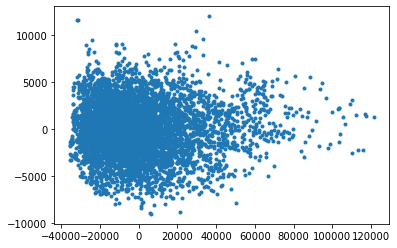

In [70]:
# Preview the PCA data in a scatter plot
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.scatter(reduced_X[:, 0], reduced_X[:, 1], marker='.')
ax

There is no easy way to infer five groups in this data cloud. Most probably, _k-means clustering_ won't provide any useful information either.

In [73]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(kmeans_y.unique()))
clustered_X = kmeans.fit_transform(reduced_X)

{'CN': 'r', 'Dementia': 'g', 'MCI': 'b'}


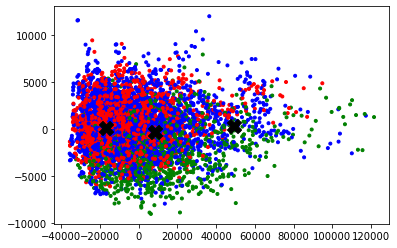

In [74]:
fig, ax = plt.subplots()
colormap = {label: color for label, color in zip(kmeans_y.unique(), 'rgbyp')}
colors = [colormap[label] for label in kmeans_y]
ax.scatter(reduced_X[:, 0], reduced_X[:, 1], marker='.', c=colors)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           marker='X', s=200, color='black', zorder=10)
print(colormap)

If we label the data points by their known label, we can see PCA cannot explain the differences. Naturally, clustering won't be able to infer this either!

### Evaluate your models

In each model we have measured the performance with different metrics:

- Regression can be assessed with MSE (mean squared error) and r-squared (the closer to 1, the better).
- Classification can be measured with the success rate (number of labels we have successfully predicted).

A _successful prediction_ is only one of the possible outcomes of a prediction. A generalization of these outcomes is done with four classes:

- True positive
- False positive
- True negative
- False negative

We normally present these four values in a confusion matrix:

<img src="images/confusion_matrix.png" />

<img src="images/confusion_matrix_pregnancy.png" />


__Exercise__

Normally these are used with two values (e.g. active vs inactive), but we can generalize to several labels. As expected, `scikit-learn` (version 0.22 or greater!) has utility functions to help us. Let's use the Random Forest classifier for as an example.

In [ ]:
from sklearn.metrics import plot_confusion_matrix
# Check the documentation to know what variables to use!
plot_confusion_matrix?

<details>
<summary>Solution</summary>
    
```python
plot_confusion_matrix(rf_classifier, rf_X_test, rf_y_test, normalize='all')
```
    
</details>

Another method to evaluate your models is the Area Under the Curve (AUC) of the Receiver Operating Characteristics (ROC). The higher the AUC (closer to 1.0), the better!

<img width="400" height="auto" src="images/rocs.png" />

* A. Ideal ROC (1.0)
* B. Good ROC (> 0.5, close to 1.0)
* C. Unhelpful ROC (0.5, as valuable as a random prediction)
* D. Worst ROC (0.0, all predictions are wrong)

__Advanced exercise__

Calculate and plot the ROC for the RF multiclass classification. There is some code in `scikit-learn` documentation [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). This is non-trivial!

### Validate your models

If you have been trying different results, you might have noticed that the results can change slightly in every attempt. How do we make sure that our good results are not just a byproduct of mere luck? How can we be sure the results are consistently valid? The answer is cross-validation: running the calculation several times and applying some statistics!



In [76]:
# import the CV helper, 10-fold
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_classifier, rf_X, rf_y, cv=10)
print(f"Avg accuracy is {scores.mean():.2f} (+/-{2*scores.std():.2f})")

Avg accuracy is 0.50 (+/-0.07)


This is why CV is _so_ important! We might have had the impression that our RF classifier was, at least, slightly better than random, but that doesn't seem to be the case _at all_.

# Discussion

Machine Learning methods can help put numbers to at-first-thought intuitive relationships between variables. While one can be tricked into _tuning_ a model to best perform at predictive levels, it is of utmost importance to evaluate _and_ validate such models with the techniques above mentioned.

# Quiz

1. Can you assume all data will be immediately ready for processing? What kind of preprocessing tasks do you need to perform if needed? Is this a trivial step that can be done until data is _good enough_ or would you consider a key step in the ML pipeline?
2. Any classifier can perform well if you tune the hyperparameters to your data. Is this statement true or false? If true, would you consider that part of the best practices in ML?
3. Try to setup a classification model that can predict Alzheimer's disease better than random.